In [345]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from datetime import timedelta
import altair as alt
import glob
import os

# CAS Data Science Projekt Sleep Analysis - Data Wrangling

## Datenquellen

**Mond Phasen**
Abruf: 03.04.2022
Quelle: `https://www.timeanddate.de/mond/phasen/` (Location: Basel). Händischer Download in ein CSV ohne Spalte Lunation und Duration
Dateien: `raw/moon/*`

**Schlafdaten**
Abruf: 18.06.2022
Quelle: Daten Export von Fitbit Schlafdaten von privatem Account, CSV Export
Dateien: `raw/sleep/*` `raw/heart/*` `raw/temp/*`

## 1. Mond-Phasen

### 1.1 Datenaufbereitung

Ich habe diese zwei kleinen Tabellen (2021, 2022) von Hand in ein Excel bzw. CSV kopiert, da der Aufwand einen Crawler zu schreiben für diese paar Zeilen dafür zu gross gewesen wäre. Nun muss ich die Daten in ein geeignetes Format bringen. Grundsätzlich möchte ich pro Datum wissen, welche Mondphase das ist.

In [346]:
# read data
moon2021_raw = pd.read_csv('raw/moon/moon-phases-2021.csv')
moon2022_raw = pd.read_csv('raw/moon/moon-phases-2022.csv')

# have a look
print(moon2021_raw.head())
print(moon2022_raw.head())

# drop unnecessary column
moon2021_raw.drop('Unnamed: 4', inplace=True, axis=1)
moon2022_raw.drop('Unnamed: 4', inplace=True, axis=1)

# have a look again
print(moon2021_raw.head())
print(moon2022_raw.head())

     New Moon First Quarter   Full Moon Third Quarter  Unnamed: 4
0  2021-01-13    2021-01-20  2021-01-28    2021-01-06         NaN
1  2021-02-11    2021-02-19  2021-02-27    2021-02-04         NaN
2  2021-03-13    2021-03-21  2021-03-28    2021-03-06         NaN
3  2021-04-12    2021-04-20  2021-04-27    2021-04-04         NaN
4  2021-05-11    2021-05-19  2021-05-26    2021-05-03         NaN
     New Moon First Quarter   Full Moon Third Quarter  Unnamed: 4
0  2022-01-02    2022-01-09  2022-01-18    2022-01-25         NaN
1  2022-02-01    2022-02-08  2022-02-16    2022-02-23         NaN
2  2022-03-02    2022-03-10  2022-03-18    2022-03-25         NaN
3  2022-04-01    2022-04-09  2022-04-16    2022-04-23         NaN
4  2022-04-30    2022-05-09  2022-05-16    2022-05-22         NaN
     New Moon First Quarter   Full Moon Third Quarter
0  2021-01-13    2021-01-20  2021-01-28    2021-01-06
1  2021-02-11    2021-02-19  2021-02-27    2021-02-04
2  2021-03-13    2021-03-21  2021-03-28    202

In [347]:

def convert_all_dates(df, format):
    """Converts all the date strings into proper datetime objects."""

    new_moon = 'New Moon'
    df[new_moon] = pd.to_datetime(df[new_moon], format=format)
    first_quarter = 'First Quarter'
    df[first_quarter] = pd.to_datetime(df[first_quarter], format=format)
    full_moon = 'Full Moon'
    df[full_moon] = pd.to_datetime(df[full_moon], format=format)
    third_quarter = 'Third Quarter'
    df[third_quarter] = pd.to_datetime(df[third_quarter], format=format)

    return df

In [348]:
format = '%Y-%m-%d'
moon2021_raw = convert_all_dates(moon2021_raw, format)
moon2022_raw = convert_all_dates(moon2022_raw, format)

print(moon2021_raw.dtypes)
print(moon2022_raw.dtypes)


New Moon         datetime64[ns]
First Quarter    datetime64[ns]
Full Moon        datetime64[ns]
Third Quarter    datetime64[ns]
dtype: object
New Moon         datetime64[ns]
First Quarter    datetime64[ns]
Full Moon        datetime64[ns]
Third Quarter    datetime64[ns]
dtype: object


In [349]:
def flatten_moon_phases(df):
    """Flattens the moon phases to dates e.g. 2020-01-01 New Moon"""
    flattened = pd.DataFrame(columns={'Date', 'Moon Phase'})
    for index, row in df.iterrows():

        first_quarter = {'Date': row['First Quarter'], 'Moon Phase': 'First Quarter'}
        flattened = flattened.append(first_quarter, ignore_index = True)

        new_moon = {'Date': row['New Moon'], 'Moon Phase': 'New Moon'}
        flattened = flattened.append(new_moon, ignore_index = True)

        third_quarter = {'Date': row['Third Quarter'], 'Moon Phase': 'Third Quarter'}
        flattened = flattened.append(third_quarter, ignore_index = True)

        full_moon = {'Date': row['Full Moon'], 'Moon Phase': 'Full Moon'}
        flattened = flattened.append(full_moon, ignore_index = True)


    return flattened

In [350]:
moon_2021 = flatten_moon_phases(moon2021_raw)
moon_2022 = flatten_moon_phases(moon2022_raw)

moon_2021.rename(columns={'Date': 'date'}, inplace=True)
moon_2022.rename(columns={'Date': 'date'}, inplace=True)

moon_2021['date'] = pd.to_datetime(moon_2021["date"])
moon_2022['date'] = pd.to_datetime(moon_2022["date"])

/var/folders/05/dt2l3w6x5vj4rljb35fc6sgr0000gn/T/ipykernel_37293/3004303789.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  flattened = flattened.append(first_quarter, ignore_index = True)
/var/folders/05/dt2l3w6x5vj4rljb35fc6sgr0000gn/T/ipykernel_37293/3004303789.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  flattened = flattened.append(new_moon, ignore_index = True)
/var/folders/05/dt2l3w6x5vj4rljb35fc6sgr0000gn/T/ipykernel_37293/3004303789.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  flattened = flattened.append(third_quarter, ignore_index = True)
/var/folders/05/dt2l3w6x5vj4rljb35fc6sgr0000gn/T/ipykernel_37293/3004303789.py:16: FutureWarning: The frame.append method is deprecated and will be removed f

In [351]:
# drop ones containing no date
moon_2021.dropna(axis=0, inplace=True)
moon_2022.dropna(axis=0, inplace=True)

### 1.2 Fertige Datensätze

In [352]:
print("File Mond Phasen 2021 Dimensionen: "+ str(moon_2021.shape))
moon_2021.tail(10)

File Mond Phasen 2021 Dimensionen: (49, 2)


,date,Moon Phase
39,2021-10-20,Full Moon
40,2021-11-11,First Quarter
41,2021-11-04,New Moon
42,2021-10-28,Third Quarter
43,2021-11-19,Full Moon
44,2021-12-11,First Quarter
45,2021-12-04,New Moon
46,2021-11-27,Third Quarter
47,2021-12-19,Full Moon
50,2021-12-27,Third Quarter


In [353]:
print("File Mond Phasen 2022 Dimensionen: "+ str(moon_2022.shape))
moon_2022.tail(10)

File Mond Phasen 2022 Dimensionen: (50, 2)


,date,Moon Phase
40,2022-11-01,First Quarter
41,2022-10-25,New Moon
42,2022-11-16,Third Quarter
43,2022-11-08,Full Moon
44,2022-11-30,First Quarter
45,2022-11-23,New Moon
46,2022-12-16,Third Quarter
47,2022-12-08,Full Moon
48,2022-12-30,First Quarter
49,2022-12-23,New Moon


In [354]:
# combined
combined_moon = moon_2021.merge(moon_2022, how='outer',on=['date','Moon Phase'])
combined_moon.to_csv('prepared/moon.csv')

### 1.3 Erste Visualisierungen

<AxesSubplot:xlabel='Moon Phase', ylabel='count'>

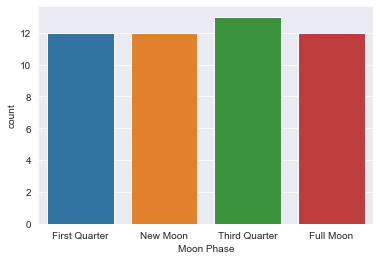

In [355]:
sns.countplot(data=moon_2021, x='Moon Phase')

<AxesSubplot:xlabel='Moon Phase', ylabel='count'>

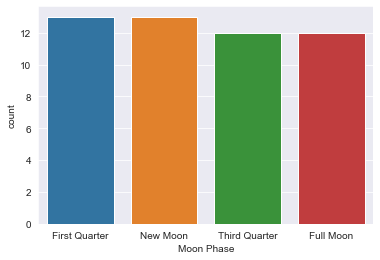

In [356]:
sns.countplot(data=moon_2022, x='Moon Phase')

In [357]:
from altair.utils.data import to_values

alt.Chart.from_dict({
    "data": to_values(moon_2021),
    "mark": "circle",
    "encoding": {
        "x": {
            "field": "date",
            "type": "temporal",
        },
        "color": {
            "field": "Moon Phase",
            "type": "nominal"
        },
         "y": {
            "field": "Moon Phase",
            "type": "nominal",
        }
    }
})

alt.Chart(...)

Die Mond-Phasen sind verteilt wie erwaret.

## 2. Fitbit - Average Heart Rate

### 2.1 Datenaufbereitung

In [358]:
def get_bpm(row):
    entry = row['value']
    return entry['bpm']

def get_confidence(row):
    entry = row['value']
    return entry['confidence']


In [359]:

# does not respect confidence yet
def process_heart_df(dataframe):
    dataframe['date'] = pd.to_datetime(dataframe['dateTime']).dt.date
    dataframe.drop(columns=['dateTime'], inplace=True)
    dataframe['bpm'] = dataframe.apply(get_bpm, axis=1)
  # dataframe['confidence'] = df.apply(get_confidence, axis=1)
    dataframe.drop(columns=['value'], inplace=True)
    dataframe = dataframe.groupby('date', sort=False)['bpm'].mean().reset_index()
    return dataframe

In [360]:
# care, this takes a while - grab a coffee

heart_path = os.path.abspath("raw/heart")
heart_filenames = glob.glob(heart_path + "/*.json")
dfs = []

for filename in heart_filenames:
    read = pd.read_json(filename)
    df = process_heart_df(read)
    dfs.append(df)

heart = pd.concat(dfs)
heart.reset_index(drop=True, inplace=True)

heart['date'] = pd.to_datetime(heart["date"])


In [361]:
heart.head()

heart = heart.groupby(['date']).mean()
heart.shape




(190, 1)

### 2.2 Fertiger Datensatz

In [362]:
heart.to_csv('prepared/heart.csv')
print("File Heart Rate Dimensionen: "+ str(heart.shape))
heart.tail(10)

File Heart Rate Dimensionen: (190, 1)


,bpm
date,
2022-06-09,59.214786
2022-06-10,56.867904
2022-06-11,63.713279
2022-06-12,60.816822
2022-06-13,62.719763
2022-06-14,61.863709
2022-06-15,73.170117
2022-06-16,64.144199
2022-06-17,75.515782


### 2.3 Erste Visualisierungen

<AxesSubplot:ylabel='Count'>

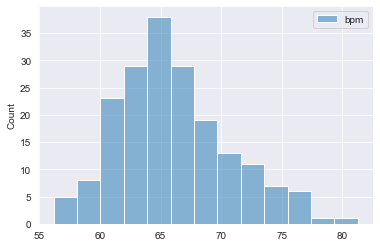

In [363]:
sns.histplot(data=heart)

Die häufigsten Vorkommnisse sind zwischen 60-70 bpm. Das scheint okay zu sein.
Die Ober- (ca. 90) und Untergrenzen (ca. 50) scheinen auch gut möglich.

## 3. Fitbit - Temperatur Abweichungen

### 3.1 Datenaufbereitung

In [364]:

def process_temp_df(dataframe):
    dataframe.drop(columns=['sensor_type'], inplace=True)
    dataframe['date'] = pd.to_datetime(dataframe['recorded_time']).dt.date
    dataframe.drop(columns=['recorded_time'], inplace=True)
    dataframe = dataframe.groupby('date', sort=False)['temperature'].mean().reset_index()
    return dataframe

In [365]:
# care, this takes a while - grab a coffee

temp_path = os.path.abspath("raw/temp")
temp_filenames = glob.glob(temp_path + "/*.csv")
temp_dfs = []

for filename in temp_filenames:
    read = pd.read_csv(filename)
    processed = process_temp_df(read)
    temp_dfs.append(processed)

temp = pd.concat(temp_dfs)
temp.reset_index(drop=True, inplace=True)
temp['date'] = pd.to_datetime(temp["date"])


In [366]:
temp.head()

,date,temperature
0,2022-03-04,-2.494845
1,2022-04-19,-2.374779
2,2022-03-10,-3.100641
3,2022-04-25,-3.082295
4,2022-06-08,-2.983674


### 3.2 Fertiger Datensatz

In [367]:
temp.to_csv('prepared/temp.csv')
print("File Temperature Deviations Dimensions: "+ str(temp.shape))
temp.tail(10)

File Temperature Deviations Dimensions: (172, 2)


,date,temperature
162,2022-01-31,-2.063657
163,2022-01-30,-2.324723
164,2022-01-24,-1.72363
165,2022-06-05,-1.596332
166,2022-01-18,-2.356942
167,2022-06-11,-2.229695
168,2022-04-28,-2.239868
169,2022-03-21,-3.247348
170,2022-03-09,-1.638228
171,2022-04-14,-2.75829


### 3.3 Erste Visualisierungen

<AxesSubplot:ylabel='Count'>

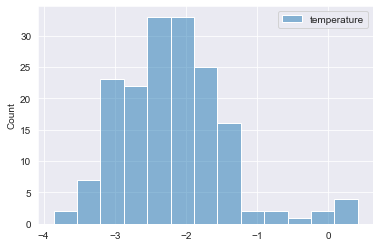

In [368]:
sns.histplot(data=temp)

## 4. Fitbit - Sleep Score

### 4.1 Datenaufbereitung

In [369]:
sleep = pd.read_csv('raw/sleep/sleep_score.csv')
sleep.sample(frac=1)
sleep.drop(columns=['sleep_log_entry_id'], inplace=True)

sleep['date'] = pd.to_datetime(sleep['timestamp']).dt.date
sleep.drop(columns=['timestamp'], inplace=True)
sleep['date'] = pd.to_datetime(sleep["date"])


In [370]:
sleep.head()

,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness,date
0,76,21,17,38,43,58,0.063905,2022-06-18
1,78,21,22,35,72,58,0.068783,2022-06-17
2,69,21,13,35,81,56,0.100899,2022-06-16
3,80,21,20,39,103,55,0.062159,2022-06-15
4,70,21,14,35,68,53,0.089536,2022-06-14


In [371]:
sleep.shape

(177, 8)

### 4.2 Fertiger Datensatz

In [372]:
sleep.to_csv('prepared/sleep.csv')
print("Sleep File Dimensionen: "+ str(sleep.shape))

Sleep File Dimensionen: (177, 8)


### 4.3 Erste Visualisierungen

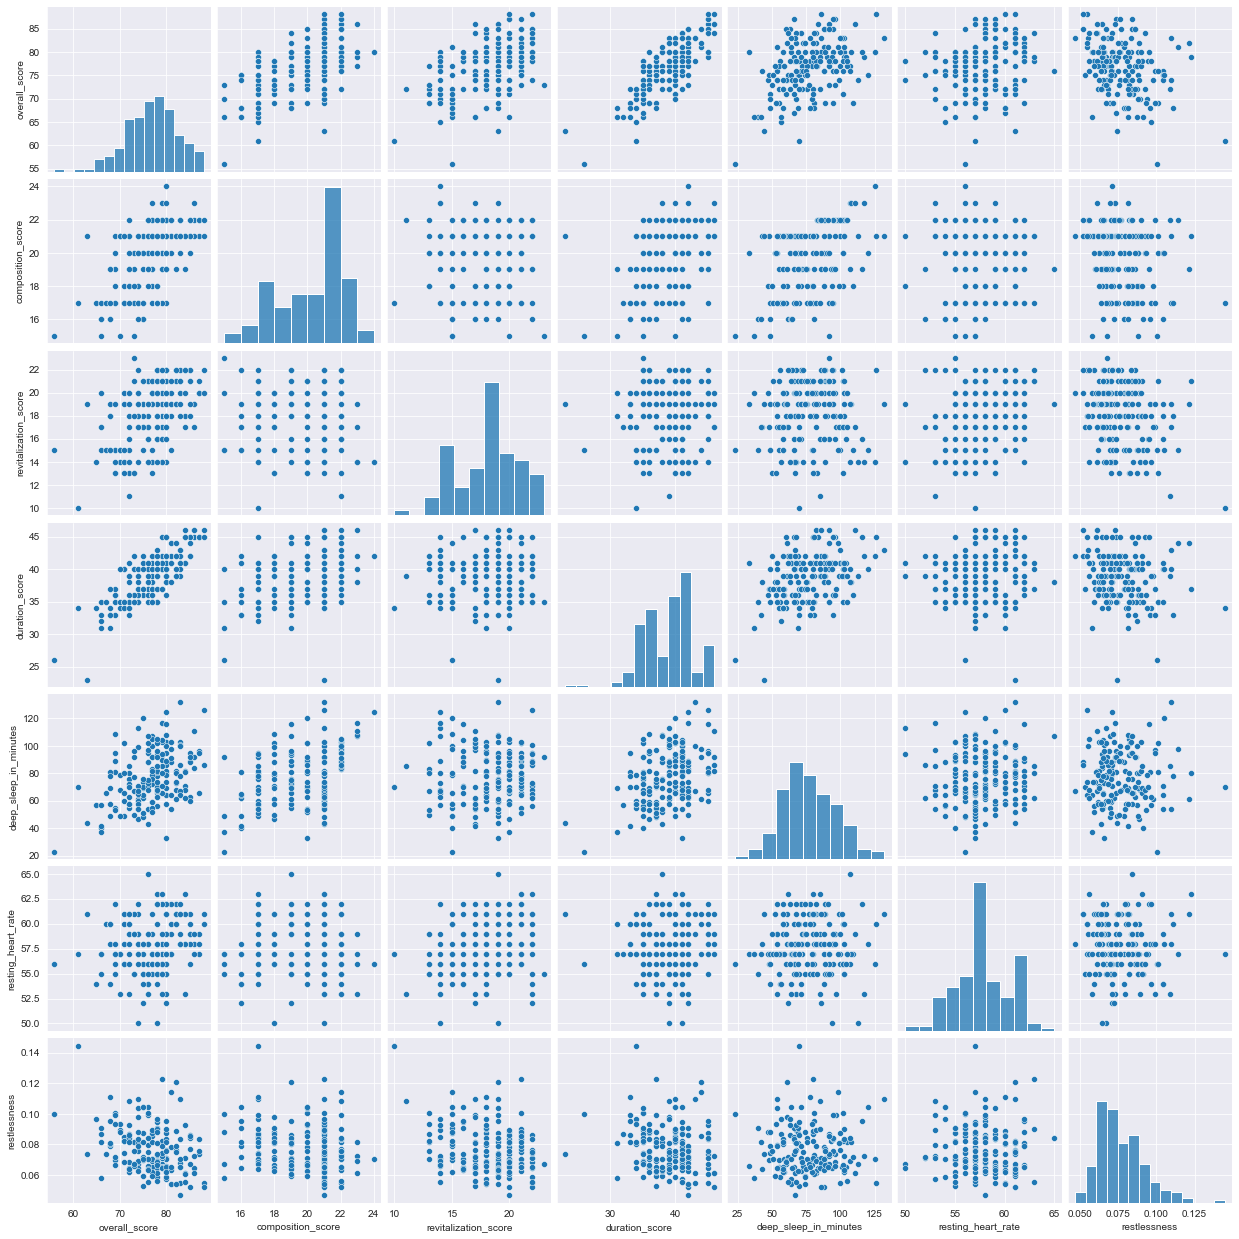

In [373]:
sns.pairplot(sleep)



In [374]:
corr = sleep.corr()
corr.style.background_gradient(cmap='coolwarm')

,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness
overall_score,1.000000,0.597456,0.489131,0.811512,0.422257,0.168851,-0.327938
composition_score,0.597456,1.000000,-0.013679,0.359225,0.413907,0.044105,-0.220316
revitalization_score,0.489131,-0.013679,1.000000,0.015142,0.025156,0.268637,-0.251330
duration_score,0.811512,0.359225,0.015142,1.000000,0.386089,0.033973,-0.187777
deep_sleep_in_minutes,0.422257,0.413907,0.025156,0.386089,1.000000,0.019782,-0.005101
resting_heart_rate,0.168851,0.044105,0.268637,0.033973,0.019782,1.000000,-0.019583
restlessness,-0.327938,-0.220316,-0.251330,-0.187777,-0.005101,-0.019583,1.000000


# Comparing + Combination of Datasets

In [375]:
def pp_shape(df, name):
    print("Dataframe "+ name+" has a shape of "+   str((df.shape)))

pp_shape(combined_moon, "moon")
pp_shape(heart, "heart rate")
pp_shape(temp, "temperature")
pp_shape(sleep, "sleep")

Dataframe moon has a shape of (99, 2)
Dataframe heart rate has a shape of (190, 1)
Dataframe temperature has a shape of (172, 2)
Dataframe sleep has a shape of (177, 8)


In [376]:
temp_sleep = temp.merge(sleep, on='date', how='left')
print(temp_sleep.shape)
temp_sleep.head(5)

(172, 9)


,date,temperature,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness
0,2022-03-04,-2.494845,67,17,15,35,66,60,0.073479
1,2022-04-19,-2.374779,75,16,17,42,62,52,0.071966
2,2022-03-10,-3.100641,88,21,22,45,126,60,0.054695
3,2022-04-25,-3.082295,56,15,15,26,23,56,0.100186
4,2022-06-08,-2.983674,75,20,19,36,69,55,0.087816


In [377]:
fitbit_data = temp_sleep.merge(heart, on='date', how='left')
fitbit_data.to_csv('prepared/fitbit_data.csv')
fitbit_data.shape

(172, 10)

In [378]:
fitbit_data.sample(frac=1)

,date,temperature,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness,bpm
43,2022-03-28,-2.877362,77,21,19,37,59,57,0.061768,65.083816
6,2022-01-15,-0.019856,61,17,10,34,70,57,0.144590,68.972063
65,2022-02-08,-2.121275,80,20,18,42,82,61,0.062563,65.943569
100,2022-02-14,-2.114907,72,18,19,35,76,58,0.084264,61.355771
165,2022-06-05,-1.596332,79,19,19,41,93,55,0.082192,58.896458
...,...,...,...,...,...,...,...,...,...,...
57,2021-12-14,-1.406046,69,20,13,36,53,57,0.093377,71.612062
26,2022-01-06,-1.656261,80,21,17,42,58,62,0.064990,73.517457
144,2022-04-02,-2.859982,69,18,15,36,109,57,0.071505,64.865656
152,2022-06-06,-1.966058,78,17,20,41,78,55,0.070107,59.796485


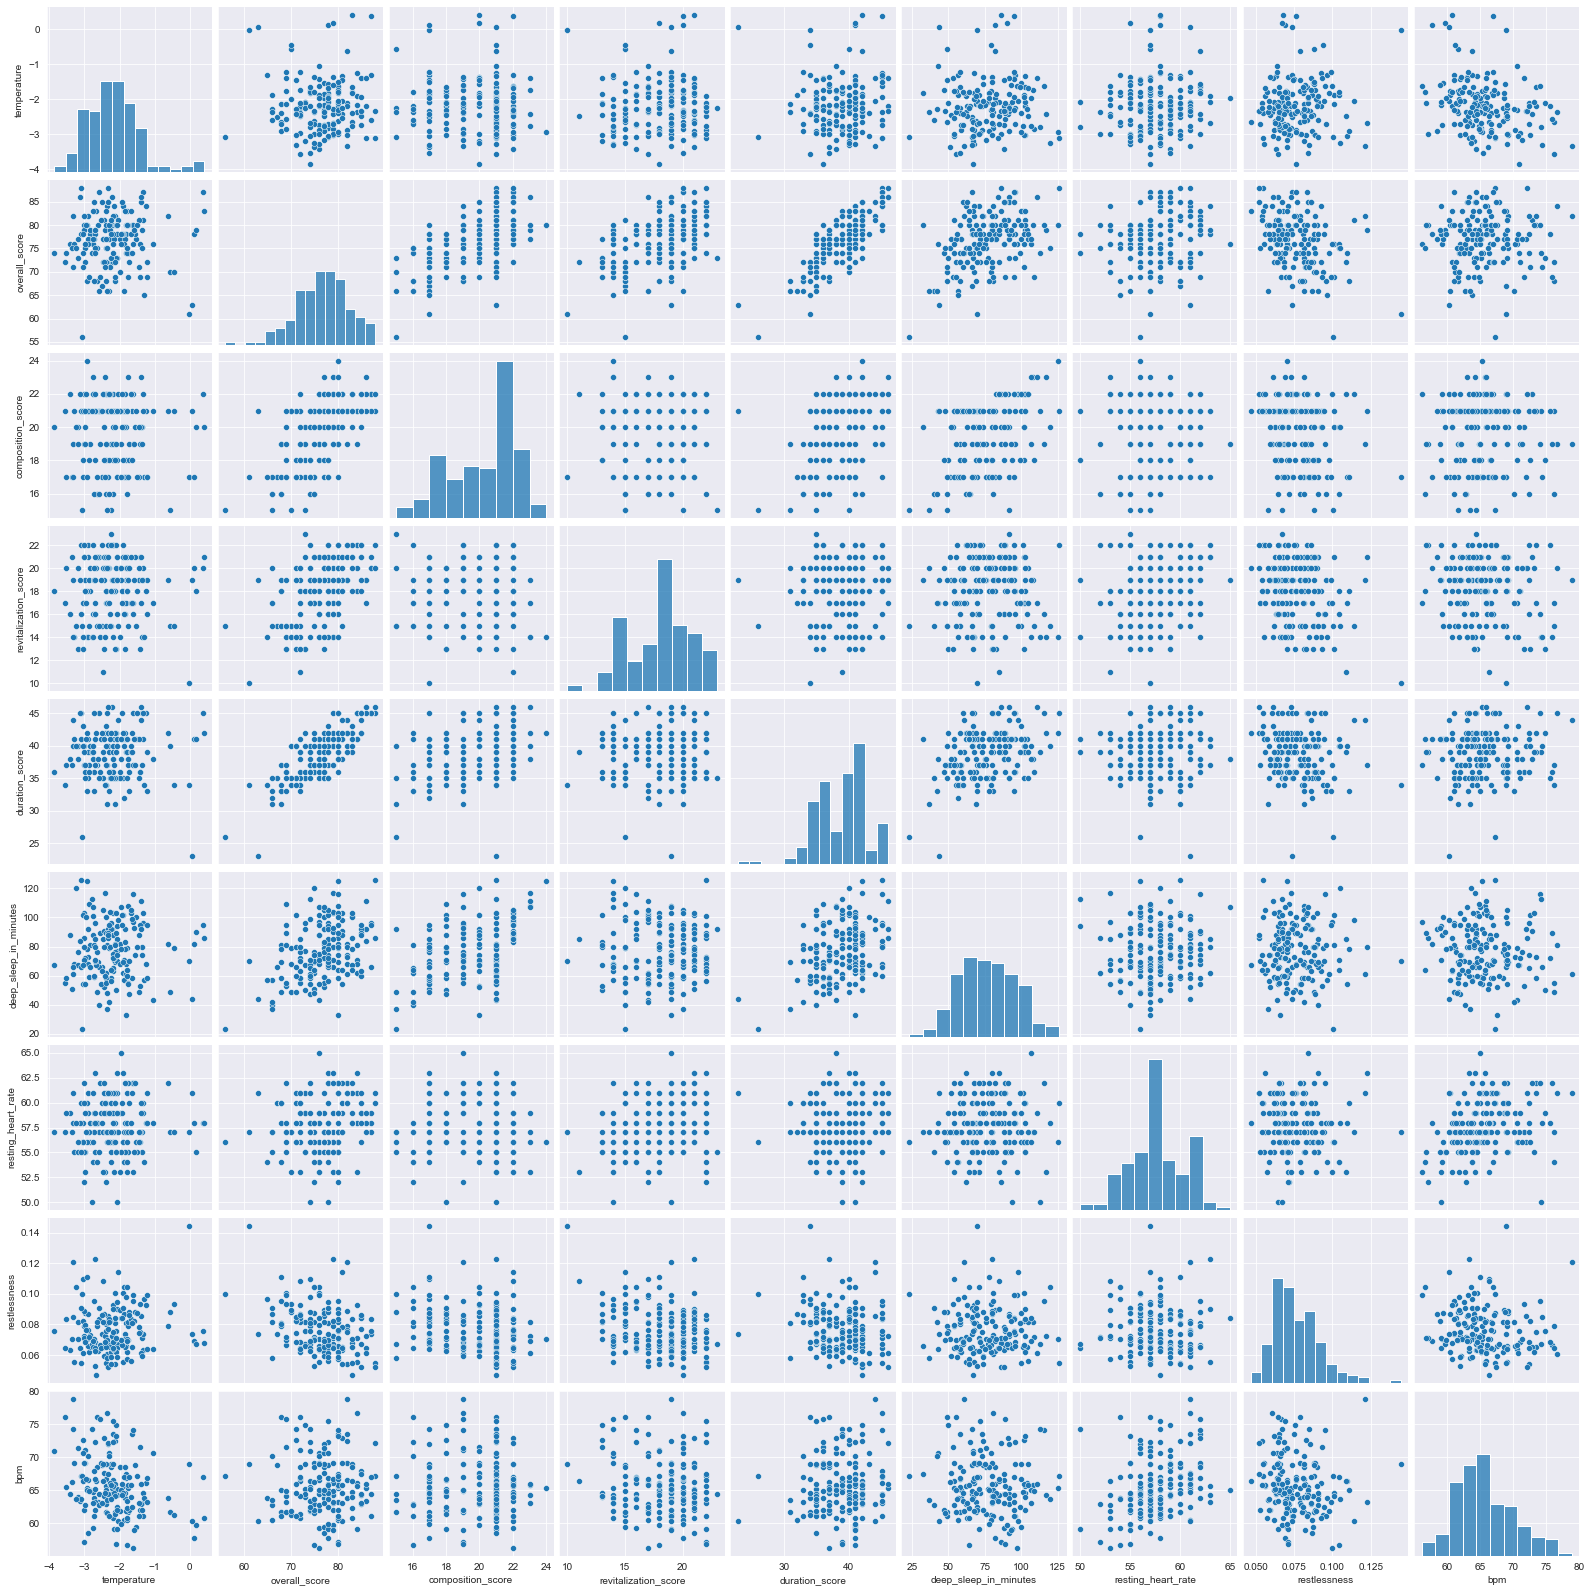

In [379]:
sns.pairplot(fitbit_data)

In [380]:
fitbit_data.to_csv('prepared/prepared-fitbit.csv')

In [381]:
corr2 = fitbit_data.corr()
corr2.style.background_gradient(cmap='coolwarm')

,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness,bpm
overall_score,1.000000,0.602817,0.496125,0.808332,0.414666,0.162794,-0.343974,0.011080
composition_score,0.602817,1.000000,-0.002098,0.360954,0.429804,0.035070,-0.240098,-0.004046
revitalization_score,0.496125,-0.002098,1.000000,0.017420,0.016142,0.270425,-0.269383,-0.096370
duration_score,0.808332,0.360954,0.017420,1.000000,0.375291,0.028201,-0.188716,0.088638
deep_sleep_in_minutes,0.414666,0.429804,0.016142,0.375291,1.000000,0.009995,-0.020678,-0.060642
resting_heart_rate,0.162794,0.035070,0.270425,0.028201,0.009995,1.000000,-0.052254,0.301544
restlessness,-0.343974,-0.240098,-0.269383,-0.188716,-0.020678,-0.052254,1.000000,-0.117301
bpm,0.011080,-0.004046,-0.096370,0.088638,-0.060642,0.301544,-0.117301,1.000000


<AxesSubplot:xlabel='date', ylabel='deep_sleep_in_minutes'>

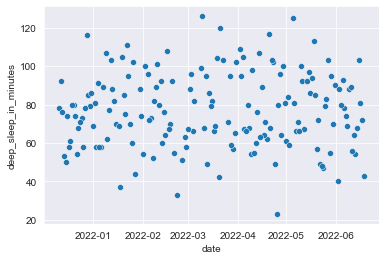

In [382]:
sns.scatterplot(x=fitbit_data['date'], y=fitbit_data['deep_sleep_in_minutes'])


In [383]:
fitbit_data['date'] = pd.to_datetime(fitbit_data["date"])
alt.Chart.from_dict({
    "data": to_values(fitbit_data),
    "mark": "circle",
    "encoding": {
        "x": {
            "field": "date",
            "type": "temporal",
        },
        "color": {
            "field": "deep_sleep_in_minutes",
            "type": "quantitative",
        },
         "y": {
            "field": "deep_sleep_in_minutes",
            "type": "quantitative",
        }
    }
})

alt.Chart(...)

In [384]:
fitbit_data.head()

,date,temperature,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness,bpm
0,2022-03-04,-2.494845,67,17,15,35,66,60,0.073479,68.873969
1,2022-04-19,-2.374779,75,16,17,42,62,52,0.071966,62.836604
2,2022-03-10,-3.100641,88,21,22,45,126,60,0.054695,67.206731
3,2022-04-25,-3.082295,56,15,15,26,23,56,0.100186,67.187992
4,2022-06-08,-2.983674,75,20,19,36,69,55,0.087816,69.163313


In [385]:
fitbit_data.shape

(172, 10)

## Combination of Moon and FitBitData

In [386]:
fitbit_data_moon = fitbit_data.merge(combined_moon, on='date', how='left')
fitbit_data_moon.shape


(172, 11)

In [387]:
fitbit_data_moon['Moon Phase'].ffill(limit=6, inplace=True)
fitbit_data_moon['Moon Phase'].bfill(limit=3, inplace=True)

In [388]:
fitbit_data_moon.head(10)

,date,temperature,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness,bpm,Moon Phase
0,2022-03-04,-2.494845,67,17,15,35,66,60,0.073479,68.873969,First Quarter
1,2022-04-19,-2.374779,75,16,17,42,62,52,0.071966,62.836604,First Quarter
2,2022-03-10,-3.100641,88,21,22,45,126,60,0.054695,67.206731,First Quarter
3,2022-04-25,-3.082295,56,15,15,26,23,56,0.100186,67.187992,First Quarter
4,2022-06-08,-2.983674,75,20,19,36,69,55,0.087816,69.163313,First Quarter
5,2022-01-01,-2.14144,68,19,18,31,69,60,0.081197,61.607115,First Quarter
6,2022-01-15,-0.019856,61,17,10,34,70,57,0.144590,68.972063,First Quarter
7,2022-01-14,-1.975761,77,21,20,36,82,59,0.089701,68.562845,First Quarter
8,2022-06-09,-2.748225,76,22,16,38,88,54,0.070640,59.214786,First Quarter
9,2022-04-24,-2.648158,68,16,15,37,49,54,0.079038,76.126033,New Moon


In [389]:
fitbit_data_moon.head(20)

,date,temperature,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness,bpm,Moon Phase
0,2022-03-04,-2.494845,67,17,15,35,66,60,0.073479,68.873969,First Quarter
1,2022-04-19,-2.374779,75,16,17,42,62,52,0.071966,62.836604,First Quarter
2,2022-03-10,-3.100641,88,21,22,45,126,60,0.054695,67.206731,First Quarter
3,2022-04-25,-3.082295,56,15,15,26,23,56,0.100186,67.187992,First Quarter
4,2022-06-08,-2.983674,75,20,19,36,69,55,0.087816,69.163313,First Quarter
5,2022-01-01,-2.14144,68,19,18,31,69,60,0.081197,61.607115,First Quarter
6,2022-01-15,-0.019856,61,17,10,34,70,57,0.144590,68.972063,First Quarter
7,2022-01-14,-1.975761,77,21,20,36,82,59,0.089701,68.562845,First Quarter
8,2022-06-09,-2.748225,76,22,16,38,88,54,0.070640,59.214786,First Quarter
9,2022-04-24,-2.648158,68,16,15,37,49,54,0.079038,76.126033,New Moon


In [390]:
fitbit_data_moon.to_csv('prepared/fitbit_data_moon.csv')